In [48]:
!pip install yfinance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf

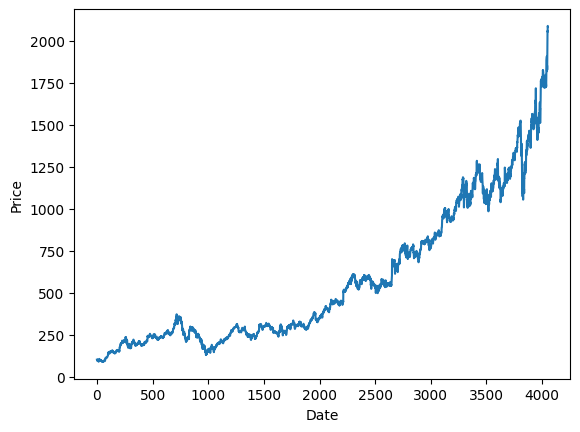

In [49]:
# Download stock data and plot the history diagram

import yfinance as yf
from datetime import datetime

stockName = "GOOGL"
stkTicker = yf.Ticker(stockName)
dfHist = stkTicker.history(start="2005-01-01", end=datetime.today().strftime('%Y-%m-%d'), interval = "1d")
dataHist = dfHist[['Open','High','Low','Close','Volume']].to_numpy()
np.set_printoptions(threshold=np.inf)
plt.style.use("default")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(dataHist[:,3])

In [50]:
# Preprocess the historical data
# Format data array to LSTM
# -----------------------------------------------------------------------------------
#|  0-4044(4045)    dataClose, dataOpen, dataHist                                    |
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
#|  1-4044(4044)    dataClose   dataset                                              |
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
#|         datasetTrain                           |   datasetTest                    |
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
#|         0-2446  xTrain             | 2447-2546 |                                  |
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
#|       0-99     |     100-2546     yTrain      |                                  |
# -----------------------------------------------------------------------------------

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# ------------------x = Close--------------------
dataset = np.array(dataHist)

dataset = dataset.reshape(-1,5)

# ------------------With scaler--------------------
minmaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True)
_dataset = minmaxScaler.fit_transform(dataset)
print("The max =", minmaxScaler.data_max_,", the Min =",minmaxScaler.data_min_)

The max = [2.10000000e+03 2.11496997e+03 2.06360010e+03 2.08883008e+03
 8.21511670e+07] , the Min = [8.77377396e+01 8.92892914e+01 8.63713684e+01 8.75825806e+01
 4.65600000e+05]


In [51]:
# Get train set and test set

sizeTrain = int(_dataset.shape[0]*0.63)
sizeTest = _dataset.shape[0] - sizeTrain
print("The length of data is:",_dataset.shape[0], \
      "\nThe length of Training is:", sizeTrain, \
      "\nThe length of Testing is:", sizeTest)
_Train = _dataset[ : sizeTrain, : ]
_Test = _dataset[sizeTrain : , : ]

The length of data is: 4053 
The length of Training is: 2553 
The length of Testing is: 1500


In [53]:
# Format data array to LSTM
# -----------------------------------------------------------------------------------
#|  0-4044(4045)    dataClose, dataOpen, dataHist                                    |
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
#|  0  |   1-4044(4044)                                                              |
# -----------------------------------------------------------------------------------
#      ------------------------------------------------------------------------------
#     |    datasetTrain                           |   datasetTest                    |
#      ------------------------------------------------------------------------------
#      ------------------------------------------------------------------------------
#     |    0-2446  xTrain             | 2447-2546 |                                  |
#      ------------------------------------------------------------------------------
#      ------------------------------------------------------------------------------
#     |   0-99     |     100-2546     yTrain      |                                  |
#      ------------------------------------------------------------------------------

DIM_LSTM = 100

def formatData(dataSet,dimLSTM):
    X,Y = [],[]
    for i in range(dataSet.shape[0] - dimLSTM):
        X.append(dataSet[i : i+dimLSTM, : ])
        Y.append(dataSet[i + dimLSTM, : ])
    X = np.array(X)
    Y = np.array(Y)
    #X = X.reshape(-1,dimLSTM)
    #Y = Y.reshape(-1,5)
    X = X.reshape(X.shape[0], X.shape[1],5)
    return X,Y

_xTrain, _yTrain = formatData(_Train, DIM_LSTM)
_xTest, _yTest = formatData(_Test, DIM_LSTM)
_yTrain = _yTrain[:,3].reshape(-1,1)
_yTest = _yTest[:,3].reshape(-1,1)
xTrain, yTrain = formatData(dataset[ : sizeTrain, : ], DIM_LSTM)
xTest, yTest = formatData(dataset[sizeTrain : , : ], DIM_LSTM)
yTrain = yTrain[:,3].reshape(-1,1)
yTest = yTest[:,3].reshape(-1,1)

In [57]:
# Build the model

import keras 
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers

UNIT_LSTM = 50

def model_1():
  model = keras.Sequential()
  model.add(LSTM(UNIT_LSTM, return_sequences = True, input_shape=(DIM_LSTM,5)))
  model.add(LSTM(UNIT_LSTM, return_sequences = True))
  model.add(LSTM(UNIT_LSTM))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer = 'adam')
  return model

def model_2():
  lstm_input = Input(shape=(DIM_LSTM, 5), name='lstm_input')
  x = LSTM(50, name='lstm_0')(lstm_input)
  x = Dropout(0.2, name='lstm_dropout_0')(x)
  x = Dense(64, name='dense_0')(x)
  x = Activation('sigmoid', name='sigmoid_0')(x)
  x = Dense(1, name='dense_1')(x)
  output = Activation('linear', name='linear_output')(x)
  model = Model(inputs=lstm_input, outputs=output, name='model_2')
  adam = optimizers.Adam(lr=0.0005)
  model.compile(optimizer=adam, loss='mse')
  return model

def model_3():
  input = Input(shape=(DIM_LSTM, 5), name='input')
  x = LSTM(UNIT_LSTM, name='lstm_0',return_sequences = True)(input)
  x = LSTM(UNIT_LSTM, name='lstm_1',return_sequences = True)(x)
  x = LSTM(UNIT_LSTM, name='lstm_2')(x)
  output = Dense(1, activation = 'sigmoid', name='dense_1')(x)
  model = Model(inputs=input, outputs=output,name = 'model_3')
  model.compile(optimizer='sgd', loss='binary_crossentropy')
  return model

model = model_1()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 50)           11200     
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 51,651
Trainable params: 51,651
Non-trainable params: 0
_________________________________________________________________


In [58]:
# Fit the model   
model.fit(x=_xTrain,y=_yTrain, epochs=50, batch_size=32, shuffle = True, validation_split = 0.1)

Epoch 1/50
69/69 [==============================] - 15s 156ms/step - loss: 0.0017 - val_loss: 7.8986e-05
Epoch 2/50
69/69 [==============================] - 10s 141ms/step - loss: 5.0378e-05 - val_loss: 2.0114e-04
Epoch 3/50
69/69 [==============================] - 10s 142ms/step - loss: 4.7836e-05 - val_loss: 1.2758e-04
Epoch 4/50
69/69 [==============================] - 10s 144ms/step - loss: 4.5557e-05 - val_loss: 1.1248e-04
Epoch 5/50
69/69 [==============================] - 11s 153ms/step - loss: 4.5668e-05 - val_loss: 6.5648e-05
Epoch 6/50
69/69 [==============================] - 10s 146ms/step - loss: 4.4851e-05 - val_loss: 2.4456e-04
Epoch 7/50
69/69 [==============================] - 10s 145ms/step - loss: 4.4930e-05 - val_loss: 6.1145e-05
Epoch 8/50
69/69 [==============================] - 10s 150ms/step - loss: 4.0874e-05 - val_loss: 1.3186e-04
Epoch 9/50
69/69 [==============================] - 10s 149ms/step - loss: 3.5883e-05 - val_loss: 6.4367e-05
Epoch 10/50
69/69 [====

In [59]:
# Make predictions

from sklearn.metrics import mean_squared_error

_predTrain = model.predict(_xTrain)
_predTest= model.predict(_xTest)
_predTrain = np.c_[_predTrain,_predTrain,_predTrain,_predTrain,_predTrain]
_predTest = np.c_[_predTest,_predTest,_predTest,_predTest,_predTest]
predTrain = minmaxScaler.inverse_transform(_predTrain)
predTest = minmaxScaler.inverse_transform(_predTest)
predTrain = predTrain[:,3]
predTest = predTest[:,3]
mean_squared_error(predTrain,yTrain)

72.00590584464145

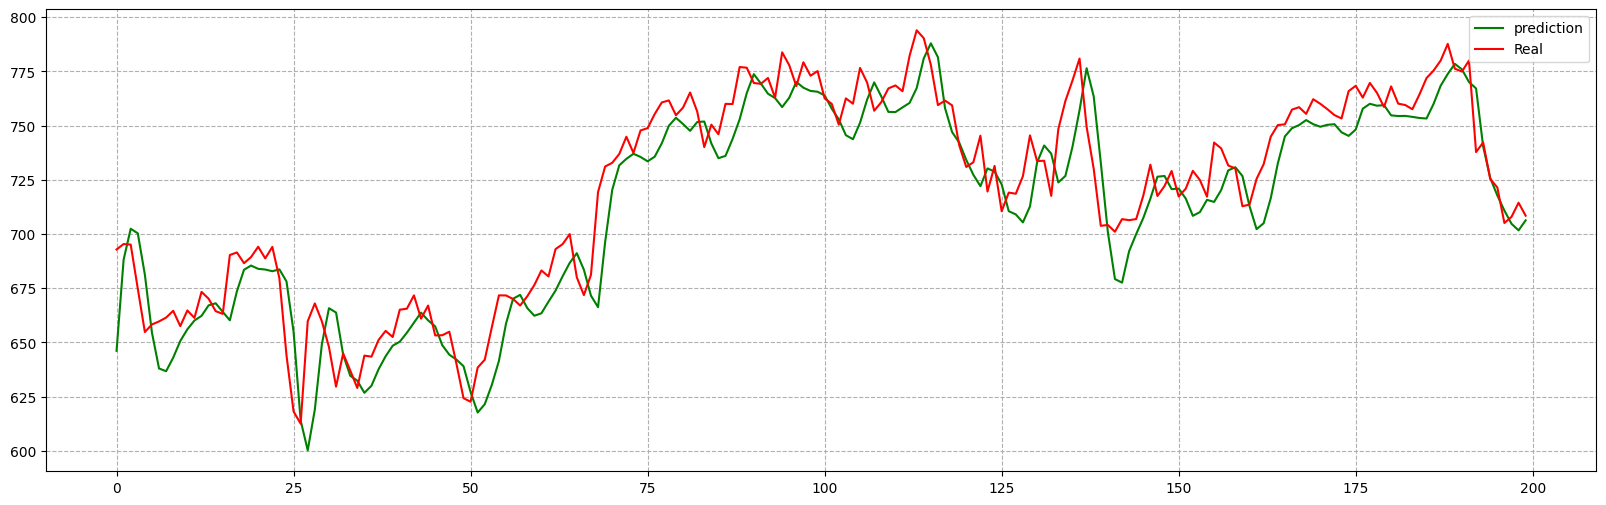

In [60]:
plt.figure(figsize=(20, 6))
plt.grid(ls='--')
plt.plot(predTest[0:200], color='green', label='prediction')
plt.plot(yTest[0:200], color='red', label='Real')
plt.legend()

In [61]:
def SumRes(pred,close,lever,isPrint):
    pred = pred.flatten()
    j = 0
    for i in range(pred.size):
        if i == 0:
            gain = 1
        else:
            if predTrain[i] > 0:
                j=j+1
                gain = gain * (close[i-1] + lever * (close[i]-close[i-1])) / close[i-1]
                if isPrint !=0:
                    print(i, "\tCurrClose:%.02f" %close[i], \
                             "  \tPredCurrGain%+.07f" %pred[i], \
                             "  \tActualGain%+.02f" %(close[i]/close[i-1]), \
                             "  \tPredLongTermGain%+.02f" %gain)
    if isPrint !=0:
        print("\n\n\nFinal gain comparasion:\t",gain,"rather than Long-Term-Gain",close[pred.size-1]/close[0],", Trading times",j)
    return gain

In [62]:
def dispLever(pred,close,):
    disp  = []
    lever = []
    l = float(0)
    while l<=10:
        disp.append(SumRes(pred,close,l,0))
        lever.append(l)
        l=l+0.1
    disp = np.array(disp).reshape(-1,1)
    lever = np.array(lever).reshape(-1,1)
    plt.figure(figsize=(10, 6))
    plt.xticks(np.linspace(0, 10, 21))
    plt.grid(ls='--')
    plt.plot(lever, disp)

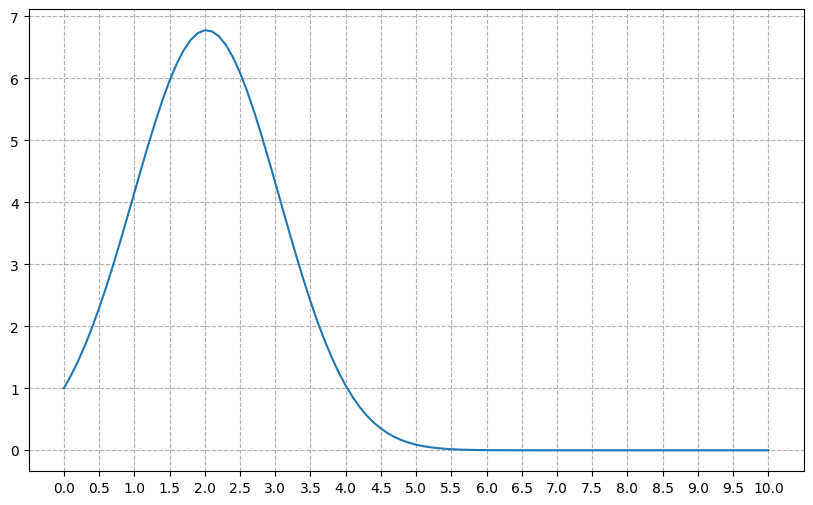

In [63]:
dispLever(predTrain,yTrain)

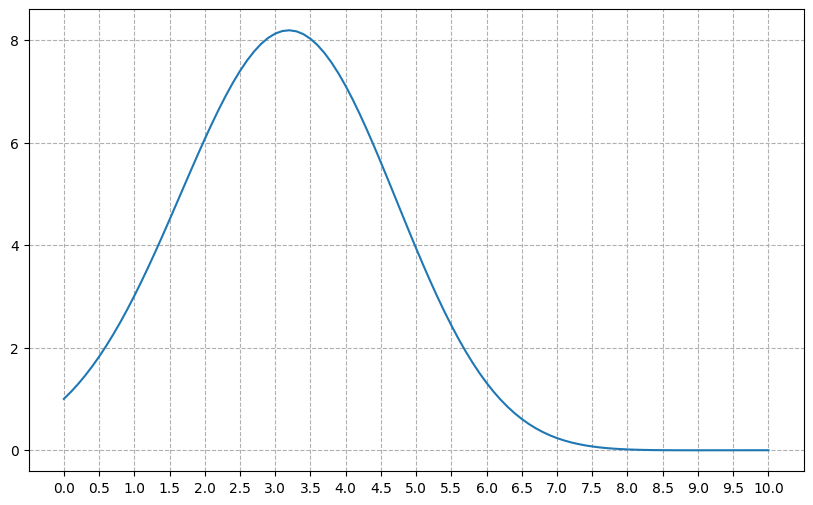

In [64]:
dispLever(predTest,yTest)

In [ ]:
SumRes(predTrain,yTrain,2.25,1) 

1 	CurrClose:133.13   	PredCurrGain+128.8464050   	ActualGain+1.03   	PredLongTermGain+1.06
2 	CurrClose:138.77   	PredCurrGain+128.9804535   	ActualGain+1.04   	PredLongTermGain+1.16
3 	CurrClose:144.14   	PredCurrGain+133.2959290   	ActualGain+1.04   	PredLongTermGain+1.26
4 	CurrClose:144.09   	PredCurrGain+141.1852264   	ActualGain+1.00   	PredLongTermGain+1.26
5 	CurrClose:140.27   	PredCurrGain+142.7373810   	ActualGain+0.97   	PredLongTermGain+1.18
6 	CurrClose:145.62   	PredCurrGain+141.3004913   	ActualGain+1.04   	PredLongTermGain+1.29
7 	CurrClose:146.71   	PredCurrGain+141.9052887   	ActualGain+1.01   	PredLongTermGain+1.31
8 	CurrClose:139.92   	PredCurrGain+144.2430267   	ActualGain+0.95   	PredLongTermGain+1.17
9 	CurrClose:143.30   	PredCurrGain+142.9758759   	ActualGain+1.02   	PredLongTermGain+1.24
10 	CurrClose:141.39   	PredCurrGain+140.9740295   	ActualGain+0.99   	PredLongTermGain+1.20
11 	CurrClose:141.52   	PredCurrGain+138.9176178   	ActualGain+1.00   	PredLong

array([6.51839414])

In [ ]:
SumRes(predTest,yTest,3.5,1) 

1 	CurrClose:692.84   	PredCurrGain+662.8400879   	ActualGain+0.99   	PredLongTermGain+0.97
2 	CurrClose:695.35   	PredCurrGain+694.4013672   	ActualGain+1.00   	PredLongTermGain+0.98
3 	CurrClose:695.10   	PredCurrGain+707.7055054   	ActualGain+1.00   	PredLongTermGain+0.98
4 	CurrClose:674.73   	PredCurrGain+713.2467651   	ActualGain+0.97   	PredLongTermGain+0.88
5 	CurrClose:654.77   	PredCurrGain+703.0169067   	ActualGain+0.97   	PredLongTermGain+0.79
6 	CurrClose:658.27   	PredCurrGain+684.6050415   	ActualGain+1.01   	PredLongTermGain+0.80
7 	CurrClose:659.66   	PredCurrGain+671.5267334   	ActualGain+1.00   	PredLongTermGain+0.81
8 	CurrClose:661.43   	PredCurrGain+667.6939697   	ActualGain+1.00   	PredLongTermGain+0.81
9 	CurrClose:664.56   	PredCurrGain+667.5033569   	ActualGain+1.00   	PredLongTermGain+0.83
10 	CurrClose:657.50   	PredCurrGain+669.1322632   	ActualGain+0.99   	PredLongTermGain+0.80
11 	CurrClose:664.72   	PredCurrGain+670.6986694   	ActualGain+1.01   	PredLong

array([7.80788694])